# Text Summarization

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive/Colab Notebooks/[HCMUE - TextMining] Summarization/'

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/[HCMUE - TextMining] Summarization


In [2]:
# !pip uninstall numpy -y
# !pip uninstall pandas -y
# !pip uninstall tqdm -y
!pip uninstall tensorflow -y

# !pip install numpy==1.19.2
# !pip install pandas==1.1.3
# !pip install tqdm==4.54.0
!pip install tensorflow==2.1.0

Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 3.9MB 20.8MB/s 
     |████████████████████████████████| 450kB 52.2MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=eb407c7807e690628a49b6319ba7f7f10700bf7373a669c34a3c113d2354752b
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    U

In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import plot_model, Sequence
from tensorflow.keras.initializers import Constant

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Embedding, Conv2D, AveragePooling2D, Reshape, 
                                     GlobalAveragePooling1D, Dropout, Dense, Concatenate)

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import gc
import re
import os
import json
import time
import string
import warnings
warnings.filterwarnings("ignore")

In [4]:
seed_value= 1907

os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

print('Tensorflow Version:', tf.__version__)

def detect_tpu():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print('Connected!')
        return True
    except:
        print('Not connected to a TPU runtime!')
        return False

tpu_activate = detect_tpu()

Tensorflow Version: 2.1.0
Not connected to a TPU runtime!


# Load data

In [6]:
path_raw_data = 'data/raw/CNNDM_Data'

filepath_tokenizer = 'notebooks/tokenizer.json'

filepath_logger = 'notebooks/log.csv'
filepath_model_plot = 'notebooks/plot_model.png'
filepath_model_save = 'notebooks/save_model.h5'
filepath_model_minloss = 'notebooks/min_loss_val.h5'

In [7]:
%%time
def read_from_txt(path):
    print('Read data from txt...')
    gc.collect()
    with open(path, 'r') as f:
        docs = f.read().split('\n')

    return docs

def read_data(path_data):
    full = read_from_txt(os.path.join(path_data, 'full.txt'))
    summ = read_from_txt(os.path.join(path_data, 'summ.txt'))

    return full, summ

data = read_data(path_raw_data)

print(len(data[0]), len(data[1]))

Read data from txt...
Read data from txt...
311940 311940
CPU times: user 8.9 s, sys: 5.39 s, total: 14.3 s
Wall time: 42.8 s


## Train - Test - Valid

In [8]:
train_full, valid_full, train_summ, valid_summ = train_test_split(data[0], data[1], test_size=0.1, random_state=42)
test_full, valid_full, test_summ, valid_summ = train_test_split(valid_full, valid_summ, test_size=0.5, random_state=42)

train = (train_full, train_summ)
valid = (valid_full, valid_summ)
test = (test_full, test_summ)

del train_full, valid_full, train_summ, valid_summ, test_full, test_summ

print('Train:', len(train[0]), len(train[1]))
print('Valid:', len(valid[0]), len(valid[1]))
print('Test:', len(test[0]), len(test[1]))

Train: 280746 280746
Valid: 15597 15597
Test: 15597 15597


# Pre-processing

## Clean text

In [9]:
%%time
def clean_text(docs):
    print('Clean text...')
    # Add space around puntuation
    docs = [re.sub(r"([?.!,])", r" \1 ", sentences) for sentences in docs]
    # Remove all character expect ("a-z", "A-Z", "0-9", ",.!?")
    docs = [re.sub(r"[^a-zA-Z?!.,0-9]+", " ", sentences).strip() for sentences in docs]

    return docs

def processing_data(samples):
    print('Processing...')
    full = clean_text(samples[0])
    summ = clean_text(samples[1])

    full = [[sentence.strip() 
                for sentence in  re.split('\? |\. |!', sentences)
                    if 1<len(sentence.strip())] 
                for sentences in full]

    print()
    return full, summ

train_full_origin = train[0]
valid_full_origin = valid[0]
test_full_origin = test[0]

train = processing_data(train)
valid = processing_data(valid)
test = processing_data(test)

print('Train:', len(train[0]), len(train[1]))
print('Valid:', len(valid[0]), len(valid[1]))
print('Test:', len(test[0]), len(test[1]))

Processing...
Clean text...
Clean text...

Processing...
Clean text...
Clean text...

Processing...
Clean text...
Clean text...

Train: 280746 280746
Valid: 15597 15597
Test: 15597 15597
CPU times: user 1min 50s, sys: 1.59 s, total: 1min 51s
Wall time: 1min 51s


## Check maxlen

In [10]:
# %%time
# print('Len sentence')
# for i in [250, 150, 100, 80, 75, 50, 40, 35, 30, 25]:
#     count = [idx for idx, sentences in enumerate(train[0]) if len(sentences) <= i]

#     print(i, ':', len(count))

# print('\nLen word')
# for i in [1500, 300, 200, 100, 90, 80, 70, 60, 50]:
#     count = [idx for idx, sentences in enumerate(train[0]) 
#                 if max([len(words.split()) for words in sentences]) <= i]

#     print(i, ':', len(count))

# gc.collect()

In [11]:
# %%time
# for len_sentence in [250, 150, 75, 50, 40, 35, 30, 25]:
#     gc.collect()
#     count_sentence = [idx for idx, sentences in enumerate(train[0]) 
#                         if len(sentences) <= len_sentence]

#     for len_word in [1500, 300, 200, 100, 90, 80, 70, 60, 50]:
        
#         count_word = [idx for idx in count_sentence 
#                         if max([len(words.split()) for words in train[0][idx]]) <= len_word]

#         print(f'{len_sentence} - {len_word}: {len(count_sentence)} - {len(count_word)}')

In [12]:
def remove_samples(data, maxlen_sentence=25, maxlen_word=80):
    gc.collect()
    list_idx = [idx for idx, sentences in enumerate(data[0]) if len(sentences) <= maxlen_sentence]

    list_idx = [idx for idx in list_idx 
                    if max([len(words.split()) for words in data[0][idx]]) <= maxlen_word]

    full = [data[0][idx] for idx in list_idx]
    summ = [data[1][idx] for idx in list_idx]

    return full, summ

train = remove_samples(train)
valid = remove_samples(valid)
test = remove_samples(test)

print('After remove samples with number of sentences and number word in sentence')
print('Train:', len(train[0]), len(train[1]))
print('Valid:', len(valid[0]), len(valid[1]))
print('Test:', len(test[0]), len(test[1]))

After remove samples with number of sentences and number word in sentence
Train: 101198 101198
Valid: 5626 5626
Test: 5675 5675


## Tokenizer

In [13]:
def load_tokenizer(path):
    print('Load tokenizer from json...')
    with open(path, "r") as f:
        token = tokenizer_from_json(f.read())
    return token

def create_tokenizer(samples, filepath_tokenizer, size_vocab=30000, new_token=False):
    gc.collect()

    # Load Tokenizer if tokenizer exist
    if not new_token and os.path.exists(filepath_tokenizer):
        return load_tokenizer(filepath_tokenizer)

    # Create new tokenizer
    print('Create new tokenizer...')
    sentence_list = [sentence 
                        for col in samples
                            for sentences in col
                                for sentence in sentences]
    print('\t- Fit on texts...')
    token = Tokenizer(oov_token='<oov>', num_words=size_vocab+2, filters='')
    token.fit_on_texts(sentence_list)
    
    print(f'\t- Save tokenizer to {filepath_tokenizer}...\n')
    to_json = token.to_json()
    with open(filepath_tokenizer, "w") as f:
        f.write(to_json)

    return token

def transform_tokenizer(token, samples):
    print('Transform tokenizer...')
    gc.collect()
    samples =  [token.texts_to_sequences(sentences) for sentences in samples]

    return samples

def get_maxlen(samples):
    maxlen_sentence = max([len(sentences) for sentences in samples])
    maxlen_word = max([len(words) for sentences in samples for words in sentences])
     
    return maxlen_sentence, maxlen_word

def padding_doc(samples, maxlen_sentence, maxlen_word):
    def pad_sentences(sentences, maxlen_sentence, maxlen_word):
        len_add = maxlen_sentence - sentences.shape[0]
        zeros = np.zeros((len_add, maxlen_word))
        return np.concatenate((sentences, zeros))

    samples = np.array([pad_sequences(sentences, maxlen=maxlen_word, padding='post')
                            for sentences in samples])

    samples = np.array([pad_sentences(sentences, maxlen_sentence, maxlen_word) 
                            for sentences in samples])
    
    return samples

In [14]:
%%time
size_vocab = 30000
token = create_tokenizer(train, filepath_tokenizer, size_vocab)

x_train = transform_tokenizer(token, train[0])
x_valid = transform_tokenizer(token, valid[0])
x_test = transform_tokenizer(token, test[0])

maxlen_sentence, maxlen_word = get_maxlen(x_train)

print()
print('Vocab size:', size_vocab)
print('Shape Full text:', maxlen_sentence, maxlen_word)
print('Train:', len(x_train))
print('Valid:', len(x_valid))
print('Test:', len(x_test))
print()

Load tokenizer from json...
Transform tokenizer...
Transform tokenizer...
Transform tokenizer...

Vocab size: 30000
Shape Full text: 25 80
Train: 101198
Valid: 5626
Test: 5675

CPU times: user 31.2 s, sys: 304 ms, total: 31.5 s
Wall time: 32.4 s


## Calculate Rouge

In [15]:
def get_ngram(st, n=1):
    words = st.split()
    return {w:words.count(w) for w in words}

class Rouge:
    def __init__(self):
        pass

    def __call__(self, hypotheses, reference):
        hypotheses = [get_ngram(hypothesis) for hypothesis in hypotheses]
        reference = get_ngram(reference)

        counts_match = [sum([min(hypothesis[word_hyp], reference[word_hyp]) 
                        for word_hyp in hypothesis.keys() 
                            if word_hyp in reference.keys()]) 
                        for hypothesis in hypotheses]

        count = sum(reference.values())

        return [count_match/count for count_match in counts_match]

reference = 'i i am am am a student'
hypotheses = ['i am am a huan', 'i am am a i huan']

rouge = Rouge()
rouge(hypotheses, reference)

[0.5714285714285714, 0.7142857142857143]

In [16]:
def cal_rouge(samples):
    y_score = [rouge(samples[0][i], samples[1][i]) for i in tqdm(range(len(samples[0])))]
    return pad_sequences(y_score,  dtype='float32', padding='post')

y_train = cal_rouge(train)
y_valid = cal_rouge(valid)
y_test = cal_rouge(test)

y_train.shape, y_valid.shape, y_test.shape

((101198, 25), (5626, 25), (5675, 25))

# Build Model

## Generator

In [17]:
class MyGenerator(Sequence):
    def __init__(self, x, y, maxlen_sentence_full, maxlen_word_full, batch_size=32):
        self.x, self.y = x, y
        self.batch_size = batch_size
        self.maxlen_sentence_full = maxlen_sentence_full
        self.maxlen_word_full = maxlen_word_full
        
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_x = self.x[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]
        
        batch_x = padding_doc(batch_x, self.maxlen_sentence_full, self.maxlen_word_full)
        batch_y = pad_sequences(batch_y, self.maxlen_sentence_full, dtype='float32')

        return batch_x, batch_y

In [18]:
train_generator = MyGenerator(x_train, y_train, 
                              maxlen_sentence, maxlen_word)

valid_generator = MyGenerator(x_valid, y_valid, 
                              maxlen_sentence, maxlen_word)

train_generator[0][0].shape, train_generator[0][1].shape

((32, 25, 80), (32, 25))

## Get GloVe embedding matrix

In [19]:
embedding_dict={}
with open('models/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors

In [20]:
embedding_matrix=np.zeros((size_vocab + 2, 100))

word_index = token.word_index

for word,i in tqdm(word_index.items()):
    if i > size_vocab + 1:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

embedding_matrix.shape

(30002, 100)

## Build model

Create new model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25, 80)]     0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 25, 80, 100)  3000200     input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 25, 80, 100)  30100       Embedding[0][0]                  
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 25, 80, 100)  30100       block1_conv1[0][0]               
__________________________________________________________________________

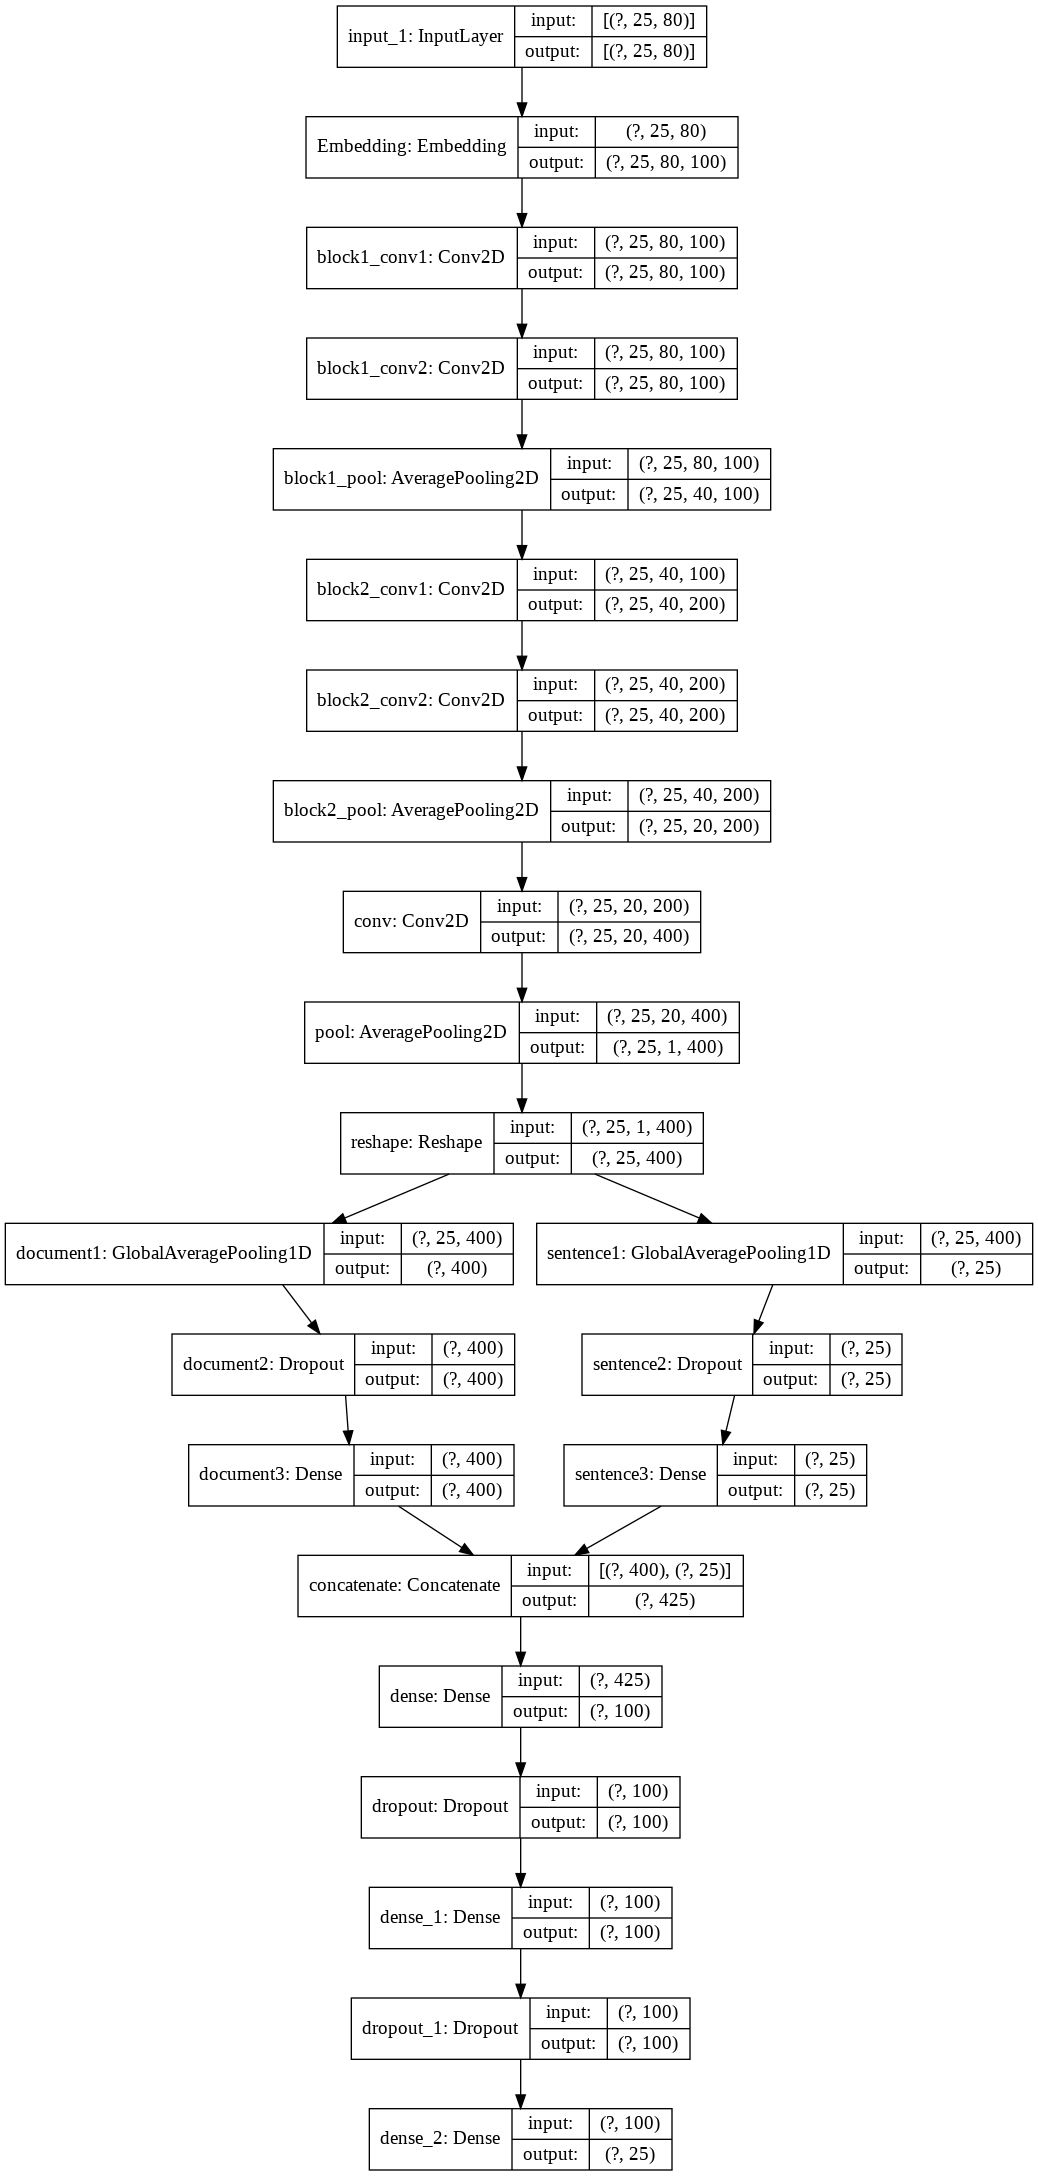

In [21]:
def build_model(input_shape=None, output_units=None, 
                size_vocab=None, 
                embedding_matrix=None,
                dropout=None, 
                filepath_model_save=None):
    
    if filepath_model_save:
        if os.path.exists(filepath_model_save):
            print('Load model...')
            model = load_model(filepath_model_save)
            return model
        else:
             print(f"No such file or directory: {filepath_model_save}")

    print('Create new model...')
    inputs = Input(input_shape)

    if embedding_matrix is not None:
        embedding = Embedding(size_vocab + 2, 100, name='Embedding',
                              trainable=False, 
                              embeddings_initializer=Constant(embedding_matrix))(inputs)
    else:
        embedding = Embedding(size_vocab + 2, 100, name='Embedding')(inputs)
    
    # Block convolution
    block1_conv = Conv2D(100, (1, 3), padding="same", activation="relu", name='block1_conv1')(embedding)
    block1_conv = Conv2D(100, (1, 3), padding="same", activation="relu", name='block1_conv2')(block1_conv)
    block1_pool = AveragePooling2D((1,2), name='block1_pool')(block1_conv)

    block2_conv = Conv2D(200, (1, 3), padding="same", activation="relu", name='block2_conv1')(block1_pool)
    block2_conv = Conv2D(200, (1, 3), padding="same", activation="relu", name='block2_conv2')(block2_conv)
    block2_pool = AveragePooling2D((1,2), name='block2_pool')(block2_conv)

    conv = Conv2D(400, (1, 3), padding="same", activation="relu", name='conv')(block2_pool)
    pool = AveragePooling2D((1,conv.shape[2]), name='pool')(conv)
    reshape = Reshape((pool.shape[1], pool.shape[3]), name='reshape')(pool)

    # Get feature for document
    x1 = GlobalAveragePooling1D(data_format='channels_last', name='document1')(reshape)
    x1 = Dropout(dropout, name='document2')(x1)
    x1 = Dense(x1.shape[1], activation='relu', name='document3')(x1)

    # Get feature for each sentences
    x2 = GlobalAveragePooling1D(data_format='channels_first', name='sentence1')(reshape)
    x2 = Dropout(dropout, name='sentence2')(x2)
    x2 = Dense(25, activation='relu', name='sentence3')(x2)

    # Concatination features of document and features of each sentence
    concat = Concatenate()([x1, x2])
    x = Dense(100, activation='relu')(concat)
    x = Dropout(dropout)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(dropout)(x)
    outputs = Dense(output_units, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


input_shape = (maxlen_sentence, maxlen_word,)
output_units = maxlen_sentence
dropout = 0

model = build_model(input_shape, output_units, 
                    size_vocab, embedding_matrix,
                    dropout,) 
                    filepath_model_save=filepath_model_save)

model.summary()

# plot_model(model, filepath_model_plot, show_shapes=True)

In [24]:
def train_model(model, x, y=None, 
                optimizer='adam', loss=None, metrics=None,
                epochs=1, 
                validation_data=None, 
                callbacks=None,
                tpu_activate=False,
                filepath_logger=None,
                filepath_model_save = None,
                filepath_model_minloss = None):

    gc.collect()
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # If not fit with Generator
    if type(x) is not MyGenerator:
        print(type(x), type(x) is not MyGenerator)
        model.fit(x, y, 
                  epochs=epochs, 
                  validation_data=validation_data,
                  callbacks=callbacks)
        
    # If use TPU fit with Generator
    elif tpu_activate:
        print('Use TPU')
        MAX_LOSS = 999999999
        min_loss_val = MAX_LOSS

        for i in range(epochs):
            gc.collect()
            start = time.time()
            print(f'Epoch {i+1}/{epochs}:')
            
            train_return = [0 for metric in model.metrics_names]
            valid_return = [0 for metric in model.metrics_names]

            # Train on training set
            for (x_batch, y_batch) in tqdm(x):
                train_tmp = model.train_on_batch(x_batch, y_batch)
                train_return = [train_return[i] + train_tmp[i] for i in range(len(train_return))]
            print()
            
            # Evaluate on Valid
            for (x_batch, y_batch) in tqdm(validation_data):
                valid_tmp = model.evaluate(x_batch, y_batch, verbose=0)
                valid_return = [valid_return[i] + valid_tmp[i] for i in range(len(valid_return))]
            print()
            
            train_return = [train_return[i]/len(x) for i in range(len(train_return))]
            valid_return = [valid_return[i]/len(validation_data) for i in range(len(valid_return))]
            
            
            print('\t',end='')
            # Show result on each epochs
            for metric, value in zip(model.metrics_names, train_return):
                print(f' - {metric}: {int(value*10000) / 10000}', end='')
                 
            for metric, value in zip(model.metrics_names, valid_return):
                print(f' - {metric}_val: {int(value*10000) / 10000}', end='')
            print()

            ## Check min loss valid
            loss_val = valid_return[0]
            if filepath_model_minloss and loss_val < min_loss_val:
                print(f'\t - val_loss improved from {min_loss_val} to {loss_val}, saving model to {filepath_model_minloss}...')
                min_loss_val = loss_val
                model.save(filepath_model_minloss)
            else:
                print(f'\t - val_loss did not improve from {min_loss_val}')
            
            ## Save model
            if filepath_model_save:
                model.save(filepath_model_save)

            if filepath_logger:
                # Check exist file log
                if os.path.exists(filepath_logger):
                    log_csv = pd.read_csv(filepath_logger)
                else:
                    print(f'\t - No such file or directory: {filepath_logger}. Create {filepath_logger}...')
                    name_columns = [metric for metric in model.metrics_names]
                    name_columns += [metric+'_val' for metric in model.metrics_names]
                    log_csv = pd.DataFrame({col:[] for col in name_columns})
                
                new_row = train_return + valid_return
                log_csv.loc[log_csv.shape[0]] = new_row
                
                # Save
                log_csv.to_csv(filepath_logger, index=False)      

            print(f'\n\tTotal time: {time.time() - start}s\n', '='*80, '\n')
            
    # If not use TPU and fit with Generator
    else:
        print("Not use TPU")
        model.fit(x, 
                  epochs=epochs, 
                  validation_data=validation_data,
                  callbacks=callbacks)
    return model

## Train

In [26]:
model = train_model(model, train_generator,
                    epochs = 32,
                    validation_data=valid_generator,
                    optimizer='adam', loss='mse', metrics=['mse'],
                    filepath_logger=filepath_logger,
                    tpu_activate=True,
                    filepath_model_save=filepath_model_save,
                    filepath_model_minloss=filepath_model_minloss)

model = load_model(filepath_model_minloss)

Use TPU
Epoch 1/32:




	 - loss: 0.0666 - mse 0.0666 - loss_val: 0.0666 - mse_val: 0.0666
	 - val_loss improved from 999999999 to 0.06667520429685035, saving model to notebooks/min_loss_val.h5...

	Total time: 148.89948773384094s

Epoch 2/32:




	 - loss: 0.066 - mse 0.066 - loss_val: 0.0664 - mse_val: 0.0664
	 - val_loss improved from 0.06667520429685035 to 0.06643995105034926, saving model to notebooks/min_loss_val.h5...

	Total time: 147.00229477882385s

Epoch 3/32:




	 - loss: 0.0658 - mse 0.0658 - loss_val: 0.0663 - mse_val: 0.0663
	 - val_loss improved from 0.06643995105034926 to 0.06632625311613083, saving model to notebooks/min_loss_val.h5...

	Total time: 147.47433876991272s

Epoch 4/32:




	 - loss: 0.0657 - mse 0.0657 - loss_val: 0.0662 - mse_val: 0.0662
	 - val_loss improved from 0.06632625311613083 to 0.06624452517875894, saving model to notebooks/min_loss_val.h5...

	Total time: 147.44870257377625s

Epoch 5/32:




	 - loss: 0.0655 - mse 0.0655 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss improved from 0.06624452517875894 to 0.0661723839584738, saving model to notebooks/min_loss_val.h5...

	Total time: 147.51597833633423s

Epoch 6/32:




	 - loss: 0.0654 - mse 0.0654 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss improved from 0.0661723839584738 to 0.06613539525477047, saving model to notebooks/min_loss_val.h5...

	Total time: 146.97065925598145s

Epoch 7/32:




	 - loss: 0.0653 - mse 0.0653 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss did not improve from 0.06613539525477047

	Total time: 142.14201426506042s

Epoch 8/32:




	 - loss: 0.0653 - mse 0.0653 - loss_val: 0.066 - mse_val: 0.066
	 - val_loss improved from 0.06613539525477047 to 0.06605034628459676, saving model to notebooks/min_loss_val.h5...

	Total time: 147.12922883033752s

Epoch 9/32:




	 - loss: 0.0652 - mse 0.0652 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss did not improve from 0.06605034628459676

	Total time: 141.86139464378357s

Epoch 10/32:




	 - loss: 0.0651 - mse 0.0651 - loss_val: 0.066 - mse_val: 0.066
	 - val_loss did not improve from 0.06605034628459676

	Total time: 142.40789556503296s

Epoch 11/32:




	 - loss: 0.0651 - mse 0.0651 - loss_val: 0.066 - mse_val: 0.066
	 - val_loss did not improve from 0.06605034628459676

	Total time: 142.03143119812012s

Epoch 12/32:




	 - loss: 0.065 - mse 0.065 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss did not improve from 0.06605034628459676

	Total time: 142.26311898231506s

Epoch 13/32:




	 - loss: 0.065 - mse 0.065 - loss_val: 0.066 - mse_val: 0.066
	 - val_loss did not improve from 0.06605034628459676

	Total time: 142.40563654899597s

Epoch 14/32:




	 - loss: 0.0649 - mse 0.0649 - loss_val: 0.066 - mse_val: 0.066
	 - val_loss did not improve from 0.06605034628459676

	Total time: 142.00625085830688s

Epoch 15/32:




	 - loss: 0.0649 - mse 0.0649 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss did not improve from 0.06605034628459676

	Total time: 142.0240342617035s

Epoch 16/32:




	 - loss: 0.0649 - mse 0.0649 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss did not improve from 0.06605034628459676

	Total time: 142.07694697380066s

Epoch 17/32:




	 - loss: 0.0648 - mse 0.0648 - loss_val: 0.0662 - mse_val: 0.0662
	 - val_loss did not improve from 0.06605034628459676

	Total time: 141.95243859291077s

Epoch 18/32:




	 - loss: 0.0648 - mse 0.0648 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss did not improve from 0.06605034628459676

	Total time: 142.01914072036743s

Epoch 19/32:




	 - loss: 0.0647 - mse 0.0647 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss did not improve from 0.06605034628459676

	Total time: 142.35624051094055s

Epoch 20/32:




	 - loss: 0.0647 - mse 0.0647 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss did not improve from 0.06605034628459676

	Total time: 142.2078981399536s

Epoch 21/32:




	 - loss: 0.0647 - mse 0.0647 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss did not improve from 0.06605034628459676

	Total time: 141.91504859924316s

Epoch 22/32:




	 - loss: 0.0646 - mse 0.0646 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss did not improve from 0.06605034628459676

	Total time: 141.64321541786194s

Epoch 23/32:




	 - loss: 0.0646 - mse 0.0646 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss did not improve from 0.06605034628459676

	Total time: 141.98318600654602s

Epoch 24/32:




	 - loss: 0.0646 - mse 0.0646 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss did not improve from 0.06605034628459676

	Total time: 141.49244689941406s

Epoch 25/32:




	 - loss: 0.0645 - mse 0.0645 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss did not improve from 0.06605034628459676

	Total time: 141.68214893341064s

Epoch 26/32:




	 - loss: 0.0645 - mse 0.0645 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss did not improve from 0.06605034628459676

	Total time: 141.00179862976074s

Epoch 27/32:




	 - loss: 0.0645 - mse 0.0645 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss did not improve from 0.06605034628459676

	Total time: 140.76279020309448s

Epoch 28/32:




	 - loss: 0.0645 - mse 0.0645 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss did not improve from 0.06605034628459676

	Total time: 141.25411820411682s

Epoch 29/32:




	 - loss: 0.0644 - mse 0.0644 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss did not improve from 0.06605034628459676

	Total time: 140.76031947135925s

Epoch 30/32:




	 - loss: 0.0644 - mse 0.0644 - loss_val: 0.0662 - mse_val: 0.0662
	 - val_loss did not improve from 0.06605034628459676

	Total time: 140.48785734176636s

Epoch 31/32:




	 - loss: 0.0644 - mse 0.0644 - loss_val: 0.0661 - mse_val: 0.0661
	 - val_loss did not improve from 0.06605034628459676

	Total time: 140.56529641151428s

Epoch 32/32:




	 - loss: 0.0644 - mse 0.0644 - loss_val: 0.0662 - mse_val: 0.0662
	 - val_loss did not improve from 0.06605034628459676

	Total time: 141.03189086914062s



In [ ]:
model_tmp = build_model(input_shape, output_units, 
                    size_vocab, embedding_matrix,
                    dropout)

model = train_model(model, train_generator, epochs = 1,
                    validation_data=valid_generator,
                    optimizer='adam', loss='mse', metrics=['mse'],
                    tpu_activate=True)

# Predict

In [44]:
def predict_summary(inputs, filepath_model_minloss, token, return_pred_raw=False):
    samples = inputs.split('\n')
    origin = samples.copy()

    # Clean
    print('Cleaning...')
    samples = [re.sub(r"([?.!,])", r" \1 ", sentences) for sentences in samples]
    samples = [re.sub(r"[^a-zA-Z?!.,0-9]+", " ", sentences).strip() for sentences in samples]

    # Processing
    print('Processing...')
    processed = [[sentence.strip() 
                    for sentence in  re.split('\?|\.|!', sentences)
                        if 1<len(sentence.strip())] 
                for sentences in samples]
                
    origin = [[sentence.strip() 
                for sentence in  re.split('\?|\.|!', sentences)
                    if 1<len(sentence.strip())] 
                for sentences in origin]

    origin = origin[0]

    # Tokenize
    x = transform_tokenizer(token, processed)

    # Padding
    x = padding_doc(x, maxlen_sentence, maxlen_word)

    # Predict
    model = load_model(filepath_model_minloss)
    pred = model.predict(x)[0][:len(origin)]    
    pred_sort = pred.argsort()[-n_sentences:]

    result = '. '.join([origin[i] for i in sorted(pred_sort)])

    if return_pred_raw:
        return result, pred_sort

    return result

In [45]:
n_sentences = 2

txt = "( cnn ) -- nine years ago he was an electrician . six months ago , he was worth some a$ 1.18 billion ( $ 1.22 billion ) australia 's mining boom having turned him into the country 's richest person under 40 years old . now , coal baron nathan tinkler , 36 , is facing a mountain of debt . his wealth has plummeted to a$ 400 million , thanks to slowing demand and falling coal prices , while his debts to a variety of creditors mount , reportedly hitting a$ 638 million . on tuesday , his personal holding company was liquidated . tinkler has had the midas touch on his way to the top of the rich list and -- until tuesday -- on the way down , too , staving off the liquidation of several of his companies . he now faces credit debt surrounding his horse racing empire , troubled sports franchises and repossession of his personal jet . while creditors have been circling for months , it was a tuesday decision of the new south wales supreme court to wind up tinkler 's mulsanne resources over an unpaid a$ 28.4 million dollar debt that suggests the former electrician 's luck may have run dry . on wednesday , the federal court place his thoroughbred horse racing and breeding empire , patinack farm administration , into liquidation with a debt of a$ 2 million . patinack farm 's cash flow problems were reported to be so severe , tinkler was trying to stem the bleeding by downsizing operations in victoria and south australia and selling horses at bargain base prices to settle a state debt . he recently settled a a$ 16.6 million dispute with mirvac over a failed land purchase in sydney and a a$ 2 million debt to the publicly listed contractor , sedgman ltd. . tinkler 's woes have impacted the australian sporting world too . his hunter sports group has reportedly fallen behind in meeting player salaries for his two prized clubs -- the a league newcastle jets football team and the newcastle knights league club . but tinkler has come up with enough money to partially pay a significant , unpaid bill for the rent of stadiums used by the teams ."

result, pred_sort = predict_summary(txt, filepath_model_minloss, token, return_pred_raw=True)

print('Full text:')
txt

Cleaning...
Processing...
Transform tokenizer...
Full text:


"( cnn ) -- nine years ago he was an electrician . six months ago , he was worth some a$ 1.18 billion ( $ 1.22 billion ) australia 's mining boom having turned him into the country 's richest person under 40 years old . now , coal baron nathan tinkler , 36 , is facing a mountain of debt . his wealth has plummeted to a$ 400 million , thanks to slowing demand and falling coal prices , while his debts to a variety of creditors mount , reportedly hitting a$ 638 million . on tuesday , his personal holding company was liquidated . tinkler has had the midas touch on his way to the top of the rich list and -- until tuesday -- on the way down , too , staving off the liquidation of several of his companies . he now faces credit debt surrounding his horse racing empire , troubled sports franchises and repossession of his personal jet . while creditors have been circling for months , it was a tuesday decision of the new south wales supreme court to wind up tinkler 's mulsanne resources over an unp

In [46]:
print('Summary:', pred_sort)

result

Summary: [9 7]


"tinkler has had the midas touch on his way to the top of the rich list and -- until tuesday -- on the way down , too , staving off the liquidation of several of his companies. while creditors have been circling for months , it was a tuesday decision of the new south wales supreme court to wind up tinkler 's mulsanne resources over an unpaid a$ 28"